# Description
The notations of the parameters used in this notebook are as followed:
- raw_df      = imported dataset
- data        = gathered samples
- target      = labels regarding each data
- scaled_data = Standardized data
- x_train     = data used for training the model
- y_train     = targets used for training the model
- x_test      = data used to test the model
- y_test      = targets used to test the model
- y_pred      = predicted targets by the model

# Parameter Selection

In [1]:
dataset_sel = 2   
# 0 for Boston Housing Price
# 1 for California Housing Price
# 2 for Tehran Housing Price

PairPlot = 0 # enable to visualize Pair-Plot
reg_model = 0
# 0 for Ridge Regression using Scikit-Learn 

import warnings
# Suppress all warnings
warnings.filterwarnings('ignore')

# Load Library

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error

# Load Dataset and Primary Data Preparation

In [3]:
if dataset_sel == 0:
    data_url = "http://lib.stat.cmu.edu/datasets/boston"
    raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
    data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
    target = raw_df.values[1::2, 2]
    raw_df = pd.DataFrame(data, columns=['Crime','ZN','INDUS','CHAS','nitric oxides','Rooms','Age','Distance','Accesibility','Tax',
                                          'pupil-teacher','B','Lower status'])
    raw_df["Price"]=target
    # One Hot Encoding
    raw_df=pd.get_dummies(raw_df)
elif dataset_sel == 1:
    from sklearn.datasets import fetch_california_housing
    housing = fetch_california_housing()
    raw_df = pd.DataFrame(housing.data, columns=['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude'])
    raw_df["Price"]=housing.target
    # One Hot Encoding
    raw_df=pd.get_dummies(raw_df)
elif dataset_sel == 2: 
    # dataset from github of Prof. Sharifzarchi
    data_url = 'https://github.com/mghadian/Machine-Learning/raw/main/housePrice.xlsx'
    raw_df = pd.read_excel(data_url, engine='openpyxl')
    raw_df=raw_df.drop('Price',axis=1)
    ## One Hot Encoding
    raw_df=pd.get_dummies(raw_df)
    column_to_move = 'PriceUSD'
    cols = [col for col in raw_df.columns if col != column_to_move] + [column_to_move]
    raw_df = raw_df.reindex(columns=cols)
    raw_df.iloc[:,-1] = raw_df.iloc[:,-1]*0.001

# Data Preparation

## Data Normalization

In [4]:
zero_array = np.zeros((raw_df.shape[0],raw_df.shape[1]-1))
scaled_data = pd.DataFrame(zero_array,columns=raw_df.columns[:-1])
for i in range(raw_df.shape[1]-1):
    if isinstance(raw_df.iloc[0,i], np.int64) and not isinstance(raw_df.iloc[0,i], bool):
        scaled_data.iloc[:,i] = (raw_df.iloc[:,i] - raw_df.iloc[:,i].mean()) / raw_df.iloc[:,i].std()
    else:
        scaled_data.iloc[:,i] = raw_df.iloc[:,i]

target=raw_df.iloc[:,-1]

## Outliers Removal

In [5]:
for i in range(scaled_data.shape[1]):
    if isinstance(scaled_data.iloc[0, i], (int, float, np.int64)) and not isinstance(scaled_data.iloc[0, i], bool):
        # Data cleaning - removing outliers based on IQR
        Q1_i = scaled_data.iloc[:,i].quantile(0.25)
        Q3_i = scaled_data.iloc[:,i].quantile(0.75)
        IQR_area = Q3_i - Q1_i
        
        lower_bound = Q1_i - 1.5 * IQR_area
        upper_bound = Q3_i + 1.5 * IQR_area
        
        scaled_data_tmp = scaled_data[(scaled_data.iloc[:,i] >= lower_bound) & (scaled_data.iloc[:,i] <= upper_bound)]
        target = target[(scaled_data.iloc[:,i] >= lower_bound) & (scaled_data.iloc[:,i] <= upper_bound)]
        scaled_data = scaled_data_tmp

# Visualization

In [6]:
scaled_data

,Area,Room,Parking,Warehouse,Elevator,Address_Abazar,Address_Abbasabad,Address_Absard,Address_Abuzar,Address_Afsarieh,...,Address_Waterfall,Address_West Ferdows Boulevard,Address_West Pars,Address_Yaftabad,Address_Yakhchiabad,Address_Yousef Abad,Address_Zafar,Address_Zaferanieh,Address_Zargandeh,Address_Zibadasht
2,-0.027607,-0.105381,True,True,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,-0.027607,-0.105381,True,True,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,-0.027607,-0.105381,True,True,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
5,-0.027607,-0.105381,True,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
6,-0.027607,-0.105381,True,True,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3474,-0.027607,-0.105381,True,True,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3475,-0.027607,-0.105381,True,True,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3476,-0.027607,-0.105381,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3477,-0.027607,-0.105381,True,True,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [7]:
if PairPlot == 1:
    import seaborn as sns
    sns.pairplot(data_df)

## Principal Component Analysis

Explained Variance Ratio Using PCA is:  [0.14792485 0.07801442]


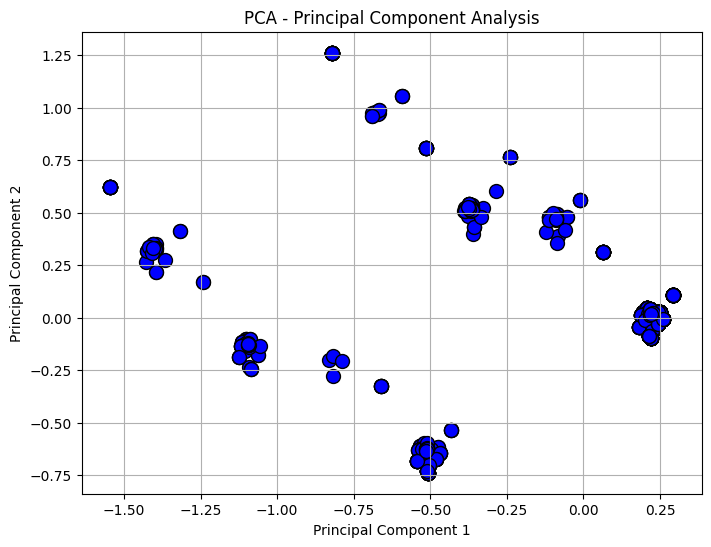

In [8]:
pca = PCA(n_components=2)
data_pca = pca.fit_transform(scaled_data)
pca_df = pd.DataFrame(data=data_pca, columns=['PC1', 'PC2'])
print('Explained Variance Ratio Using PCA is: ',pca.explained_variance_ratio_)
# Visualizing the principal components
plt.figure(figsize=(8, 6))
plt.scatter(pca_df['PC1'], pca_df['PC2'], c='blue', edgecolor='k', s=100)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA - Principal Component Analysis')
plt.grid(True)
plt.show()

# Creation of Training & Test Data

In [9]:
x_train,x_test,y_train,y_test=train_test_split(scaled_data,target,test_size=0.3, random_state=42)

# Regression

## Regression Using SK-Learn

In [ ]:
if reg_model == 0:
    degrees = [2, 4, 8, 10]
    lambdas = [10, 1, 1e-4, 1e-8, 1e-12, 1e-14]
    
    ridge_rmse_train = np.zeros((len(degrees), len(lambdas)))
    ridge_rmse_test = np.zeros((len(degrees), len(lambdas)))
    
    for degree_idx, degree in enumerate(degrees):
        for lambda_idx, lambda_val in enumerate(lambdas):
            x_train_poly = polynomial_features(x_train,degree)
            x_test_poly = polynomial_features(x_test,degree)

            ridge_model = Ridge(alpha=lambda_val)
            ridge_model.fit(x_train_poly, y_train)
            y_train_pred_ridge = ridge_model.predict(x_train_poly)
            y_test_pred_ridge = ridge_model.predict(x_test_poly)
    
            ridge_rmse_train[degree_idx, lambda_idx] = mean_squared_error(y_train, y_train_pred_ridge)
            ridge_rmse_test[degree_idx, lambda_idx] = mean_squared_error(y_test, y_test_pred_ridge)
    
    # plot RMSE
    plt.figure(figsize=(10, 6))
    
    for degree_idx, degree in enumerate(degrees):
        plt.plot(lambdas, ridge_rmse_test[degree_idx], marker='x', label=f'Ridge - Degree {degree}')
    plt.xscale('log')
    plt.xlabel('Regularization Parameter (λ)')
    plt.ylabel('RMSE')
    plt.title('RMSE for Ridge at Different Polynomial Degrees')
    plt.legend()
    plt.show()
    
    m = np.unravel_index(np.argmin(ridge_rmse_test), ridge_rmse_test.shape)
    
    x_train_poly = polynomial_features(x_train,degrees[int(m[0])])
    x_test_poly = polynomial_features(x_test,degrees[int(m[0])])
    ridge_model = Ridge(alpha=lambdas[int(m[1])])
    ridge_model.fit(x_train_poly, y_train)
    y_pred = ridge_model.predict(x_test_poly)

# Performance Analysis

In [ ]:
    plt.scatter(y_test,y_pred)
    plt.xlabel('Real Target')
    plt.ylabel('predictet Target')
    plt.show()
    mse=mean_squared_error(y_test,y_pred)
    print("Regresion MSE is: ", mse)